# Checklist
 - Implement the 14 different lattice types
 - Use vector equations for things like limits to make plotting easier
 
## Next projects:
 - Lattice planes
 - Reciprocal lattices and the Wigner Seitz cell (bisecting lines, on/off switch)
 - Scattering along lattice planes
 - 2D band structure
 - Wave-packet applet
 - bloch functions

In [1]:
# Let's get the importing out of the way.
# Numpy for calculations, matplotlib for plotting.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Make the matplotlib plots interactive
%matplotlib notebook

In [10]:
# Inputs

# Lattice vectors (3 vectors of length 3)
a1 = np.array([1/2, 1/2, 0])
a2 = np.array([1/2, 0, 1/2])
a3 = np.array([0, 1/2, 1/2])
# Array of basis vectors
basis = np.array([[0, 0, 0]])
# Colors for each of the basis vectors
colors = ('xkcd:cement','b','b','b')
# Size multiplier for each of the atoms. Default is 1
sizes = (2,1,1,1)


# Gridline type:
# Hard: lines along cartesian axes at integer spacings
# Soft: Lines along cartesian axes. Takes into account nonequal lattice spacing
# LatticeVectors: Lines along the latticevectors (only on lattice points)
GridType = "soft"

# Limit type:
# Hard: Sets a hard limit on the plotting boundary (default  x = y = z = [0,2])
# Dynamic: Sets the limits as max(nx*a1,ny*a2,nz*a3), so we include nx unitcells in the a1 direction, etc.
# WDynamic: Sets the limits r_min = n_min*[a1 a2 a3] and likewise for n_max
LimType = "dynamic"
Maxs = [2,2,2]
Mins = [0,0,0]


In [11]:
# Calculates the limits on the coordinates (the plot box), and the limits on the basis vector ranges
def FindLimits(LimType, a1, a2, a3, Min = [0,0,0], Max = [2,2,2]):
    # If we have hard limit types we just pass the min and max as coordinate limits
    # And calculate limits of the basis vector ranges based on coordinate limits
    
    # THIS METHOD IS UGLY BECAUSE WE DIVIDE BY 0 AND GET NAN AND INF. I NEED TO CLEAN IT UP
    if LimType.lower() in "hard":
        r_min, r_max = np.array(Min), np.array(Max)
        lattice = np.array((a1,a2,a3))
        # Ideally we want n1_max * a1 = r_max. But they're not (generally) parallel.
        # So what we do is we dissolve into components, so r_max_x/a1_x = nx_max and similarly for the other components
        # But we want nx_max to be an integer, so we take the ceiling value (round up) to allow for "spillage"
        # And then we take the maximal value of the three coordinate ratios (again, for extra spillage).
        # We do the same procedure (but with floor and minimum) for the n_min
        
        # Let's get rid of those pesky infinities and nans (from x/0 and 0/0 respectively). Just replace by 0
        max_quot = r_max/lattice
        min_quot = r_min/lattice
        max_quot[np.isnan(max_quot) + np.isinf(max_quot)] = 0
        min_quot[np.isnan(min_quot) + np.isinf(min_quot)] = 0
        n_max = np.amax(np.ceil(max_quot),0)
        n_min = np.amin(np.floor(min_quot),0)
        
    
    # For dynamic limits we pass Min and Max as limits of basis vector range
    # and calculate coordinate limit based on basis vector range
    elif LimType.lower() in "dynamic":
        n_min, n_max = np.array(Min), np.array(Max)
        lattice = np.array((a1,a2,a3))
        # Take the max value for each of the cardinal directions, 
        # for the three scaled lattice vectors (so x_max is max x value of Max[0]*a1, Max[1]*a2 and Max[2]*a3).
        # this can be done by multiplying the transposed lattice matrix by the n_max vector, then taking max value
        max_vects = n_max * lattice
        r_max = np.amax(max_vects,0)
        # Similar for minimums:
        min_vects = n_min * lattice
        r_min = np.amin(min_vects,0)
    
    # Different type of coordinate limits. Take r_max as sum(lattice*max) 
    # Works well for orthogonal or near-orthogonal lattice vectors
    elif LimType.lower() in "wdynamic":
        n_min, n_max = np.array(Min), np.array(Max)
        lattice = np.array((a1,a2,a3))
        r_max = np.sum(n_max*lattice,0)
        r_min = np.sum(n_min*lattice,0)
        
    else:
        print("You did poop...")
    # And lastly we return the relevant arrays, with n_min/max -+ 2, to allow for "spillage"
    # Also, let's make sure n_min/max are arrays of integers. Don't worry, they've already been rounded
    return r_min, r_max, n_min.astype('int') - 2, n_max.astype('int') + 2

In [12]:
size_default = 36


# Input sanitization:
# We need the number of basis-vectors. 
# If there is only 1 basis vector, then len(np.shape(basis)) == 1
# otherwise the length is 2, and the first element is number of basis vectors
length_basis = np.shape(basis)
if len(length_basis) == 1:
    N_basis = 1
elif len(length_basis) > 1:
    N_basis = length_basis[0]

# Make a list, N_basis long, for the colors and sizes,
# if they're not specified.
c_name = colors.__class__.__name__
if c_name == "str":
    c = colors
    colors = []
    for i in range(N_basis):
        colors.append(c)
elif c_name == "list" and len(colors) < N_basis:
    c = colors[0]
    colors = []
    for i in range(N_basis):
        colors.append(c)

s_name = sizes.__class__.__name__
if s_name == "int" or s_name == "float":
    s = sizes
    sizes = []
    for i in range(N_basis):
        sizes.append(s)
elif s_name == "list" and len(sizes) < N_basis:
    s = sizes[0]
    sizes = []
    for i in range(N_basis):
        sizes.append(s)
        
# Test for orthogonality: Not actually needed yet
def orthogonality(a1,a2,a3):
    ortho12 = np.isclose(0,np.dot(a1,a2))
    ortho13 = np.isclose(0,np.dot(a1,a3))
    ortho23 = np.isclose(0,np.dot(a2,a3))
    if ortho12 and ortho13 and ortho23:
        return True
    else:
        return False

        
# set the range of lattice vectors to be calculated
r_min, r_max, n_min, n_max = FindLimits(LimType,a1,a2,a3,Mins,Maxs)

# Calculate the amount of atomic positions to be calculated
numAtoms = (n_max[0] + 1 - n_min[0]) * (n_max[1] + 1 - n_min[1]) * (n_max[2] + 1 - n_min[2]) * N_basis

# Make a zero array for all of the atomic positions. numAtoms in one direction and 3 in the other (coordinates)
AtomicPositions = np.zeros((numAtoms, 3))
# Empty lists for colors, sizes and whether or not they're lattice points
AtomicColors = []
AtomicSizes = []
LatticePosition = []


# Loop over all chosen linear combinations of basis vectors and plot each 
counter = 0
for nx in range(n_min[0], n_max[0] + 1):
    for ny in range(n_min[1], n_max[1] + 1):
        for nz in range(n_min[2], n_max[2] + 1 ):
            lattice_position = nx * a1 + ny * a2 + nz * a3
            
            for n_atom in range(N_basis):
                AtomicPositions[counter,] = lattice_position + basis[n_atom,]
                AtomicColors.append(colors[n_atom])
                AtomicSizes.append(size_default * sizes[n_atom])
                if (AtomicPositions[counter,] == lattice_position).all():
                    LatticePosition.append(True)
                else:
                    LatticePosition.append(False)
                counter += 1

# Another way to do this is to use itertools.product to create all permutations of -2,...,4 with repeat of 3
# And then use np.asarray() to convert this into a numpy array. The "problem" is that this doesn't allow
# one to have nx_max =/= ny_max, etc. All ranges must be equal.
# I should check to see which is fastest.
# Strike that above problem. Just pass it a list for each coordinate with the range and use no repeat.
# AtomicCoefficients = np.asarray(list(itertools.product(x,y,z)))
# Where x,y,z is list of integers from nx_min to nx_max etc.
# This would yield list of coefficients (nx,ny,nz), then we just multiply the first dimension by a1, the
# second by a2 and so on.
# But not now

In [13]:
# A function to highlight points that are outside the limits of the plot
def Limiter(l, r_min = np.array([0,0,0]), r_max = np.array([2,2,2])):
    rows = []
    num,_ = np.shape(l)
    # loop over all row ID's
    for rowID in range(num):
        # if the atom is outside the limits, we append the row ID to a list
        row = l[rowID,]
        # (it's actually easier and prettier to check if they're inside)
        inside_x = r_min[0] <= row[0] <= r_max[0]
        inside_y = r_min[1] <= row[1] <= r_max[1]
        inside_z = r_min[2] <= row[2] <= r_max[2]
        inside = inside_x and inside_y and inside_z
        if not inside:
            rows.append(rowID)
    return rows

atoms,dims = np.shape(AtomicPositions)
# Get the rows with the function above
rows = Limiter(AtomicPositions, r_min, r_max)
# delete all rows (axis 0 of the array) that are outside the limits 
AtomicPositions = np.delete(AtomicPositions, rows, 0);
# Go through the list of rows to delete in reverse order, and delete what's needed from colors and sizes
for ID in sorted(rows, reverse = True):
    del AtomicColors[ID]
    del AtomicSizes[ID]
    del LatticePosition[ID]

In [14]:
# Let's try and create some grid lines along the lattice vectors

# some observations regarding grid lines:
# - if we go along a lattice vector to a point, then we need gridlines that are along the direction of the other two lattice vectors
# A naïve approach would be to just plot 3 lines for each atomic position (after limiting). 
# This would create multiple copies of some gridlines, but it's an easy solution. Let's see how long it takes to compute!

# Create the plotting parameter for the gridlines.
# They use the equation r = r0+t*a, where:
# r0 is a fixed point (atomic position)
# a is a vector giving the direction of the gridline (lattice vector)
# t is a scaling parameter, creating the points along the line.
# We use halfinteger steps for t. That way we know that we'll properly hit other atomic positions.
# if we used linspace this wouldn't be the case

def CreateLines(points, v1, v2, v3, r_min = np.array([0,0,0]), r_max = np.array([2,2,2])):
    t = np.arange(-10,10,0.5)

    lines = []

    # Create all gridlines needed and append them to the lines-list
    numPoints = np.shape(points)[0]
    for rowID in range(numPoints):
        CurrentPoint = points[rowID,]
        line1 = CurrentPoint + np.outer(t,v1)
        line2 = CurrentPoint + np.outer(t,v2)
        line3 = CurrentPoint + np.outer(t,v3)
        lines.append([line1,line2,line3])

    # run through each line and clip points outside limits
    pruned_lines = []
    for point in lines:
        for line in point:
            # Get the points outside the plot and delete them
            rows = Limiter(line, r_min, r_max)
            line = np.delete(line,rows,0)

            # Because we're working with arrays we're passing copies, we need to append the pruned lines to a new list
            # And let's only add them if there are actually any points to plot
            line_length,_ = np.shape(line)
            if line_length > 0:
                pruned_lines.append(line)
    return pruned_lines



<IPython.core.display.Javascript object>


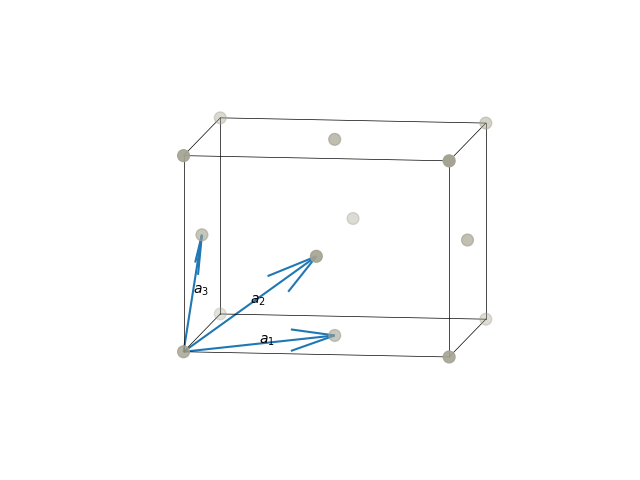

In [15]:
# Create the figure
fig = plt.figure()
ax = fig.gca(projection = "3d")

# Plot atoms. For now a single size and color
ax.scatter(AtomicPositions[:,0], AtomicPositions[:,1], AtomicPositions[:,2], c = AtomicColors, s = AtomicSizes)


# Create grid lines
g_col = 'k'
g_w = 0.5


lowGrid = GridType.lower()
if lowGrid in "hard":
    for nx in range(int(np.ceil(r_min[0])), int(np.floor(r_max[0])) + 1):
        for ny in range(int(np.ceil(r_min[1])), int(np.floor(r_max[1])) + 1):
            ax.plot(np.array([nx, nx]), np.array([ny, ny]), np.array([np.ceil(r_min[2]), np.floor(r_max[2])]), c = g_col, linewidth = g_w)

        for nz in range(int(np.ceil(r_min[2])), int(np.floor(r_max[2])) + 1):
            ax.plot(np.array([nx, nx]), np.array([np.ceil(r_min[1]), np.floor(r_max[1])]), np.array([nz, nz]), c = g_col, linewidth = g_w)

    for ny in range(int(np.ceil(r_min[1])), int(np.floor(r_max[1])) + 1):
        for nz in range(int(np.ceil(r_min[2])), int(np.floor(r_max[2])) + 1):
            ax.plot(np.array([np.ceil(r_min[0]), np.floor(r_max[0])]), np.array([ny, ny]), np.array([nz, nz]), c = g_col, linewidth = g_w)

elif lowGrid in "latticevectors":
    # gridlines along lattice vectors - really messy for non-orthogonal latticevectors
    pruned_lines = CreateLines(AtomicPositions[LatticePosition], a1, a2, a3, r_min, r_max)
    for line in pruned_lines:
        ax.plot(line[:,0],line[:,1],line[:,2],c=g_col,linewidth=g_w)
        
elif lowGrid in "soft":
    # A Way of finding atoms on cartesian axes
    # bool array of atoms with x = 0 and y = 0
    x0 = AtomicPositions[:,0] == 0
    y0 = AtomicPositions[:,1] == 0
    z0 = AtomicPositions[:,2] == 0
    
    # Get Lattice spacings
    # z-values of atoms on the z-axis
    z_vals = AtomicPositions[x0*y0,2]
    # Keep those with z > 0
    z_vals = z_vals[z_vals > 0]
    # Take the minimum as the lattice spacing
    a_z = np.min(z_vals)

    y_vals = AtomicPositions[x0*z0,1]
    y_vals = y_vals[y_vals > 0]
    a_y = np.min(y_vals)

    x_vals = AtomicPositions[y0*z0,0]
    x_vals = x_vals[x_vals > 0]
    a_x = np.min(x_vals)
    
    for nx in np.arange(r_min[0], r_max[0] + 1, a_x):
        for ny in np.arange(r_min[1], r_max[1] + 1, a_y):
            ax.plot(np.array([nx, nx]), np.array([ny, ny]), np.array([r_min[2], r_max[2]]), c = g_col, linewidth = g_w)

        for nz in np.arange(r_min[2], r_max[2] + 1, a_z):
            ax.plot(np.array([nx, nx]), np.array([r_min[1], r_max[1]]), np.array([nz, nz]), c = g_col, linewidth = g_w)

    for ny in np.arange(r_min[1], r_max[1] + 1, a_y):
        for nz in np.arange(r_min[2], r_max[2] + 1, a_z):
            ax.plot(np.array([r_min[0], r_max[0]]), np.array([ny, ny]), np.array([nz, nz]), c = g_col, linewidth = g_w)
    
else:
    print("No Gridlines Chosen")

# plot lattice vectors
ax.quiver(0, 0, 0, a1[0], a1[1], a1[2])
ax.quiver(0, 0, 0, a2[0], a2[1], a2[2])
ax.quiver(0, 0, 0, a3[0], a3[1], a3[2])
ax.text(a1[0]/2, a1[1]/2, a1[2]/2, '$a_1$')
ax.text(a2[0]/2, a2[1]/2, a2[2]/2, '$a_2$')
ax.text(a3[0]/2, a3[1]/2, a3[2]/2, '$a_3$')

# Set limits, orthographic projection (so we get the beautiful hexagons), no automatic gridlines, and no axes
ax.set_xlim([r_min[0], r_max[0]])
ax.set_ylim([r_min[1], r_max[1]])
ax.set_zlim([r_min[2], r_max[2]])
ax.set_proj_type('ortho')
ax.grid(False)
plt.axis('off')

# make the panes transparent (the plot box)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))